---
## Technical Report Notebook 4
---
### Modelling Extension - Hailstorm Severity + Earthquake Classification Investigations

This notebook extends the tweet investigations into two different classificiation exercises, to answer the following questions:

    1. Can tweets predict hail events of differing magnitude?
    2. Can tweets predict other types of natural catastrophes?
    
---

### 1. Hail Severity Test

Now we know that tweets can effectively predict hail using a classification algorithm, a secondary investigation event severity will be conducted. The purpose of this is to investigate whether the language used in the more severe Brisbane (2014) event is different to Sydney (2015).

To do this I will adjust the classification exercise using the event ID's as classes:

- Brisbane Hail (Cat_ID - 144):   **1**
- Sydney Hail (Cat_ID - 154):   **0**

In [14]:
# Import modelling libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [15]:
# Import tweet data
hail_tweet_text = pd.read_csv("./hail_tweet_text.csv")
# Drop Index column
hail_tweet_text.drop('Unnamed: 0',axis=1,inplace=True)

In [16]:
# Create Brisbane and Sydney Event classes to test severity

# Create subset dataframe for hail-only tweets
hail_tweet_text_hail = hail_tweet_text.ix[hail_tweet_text['hail'] > 0]                            

# Create new target variable
hail_tweet_text_hail['event_class'] = 0

# Set Brisbane event to 1
hail_tweet_text_hail.ix[hail_tweet_text_hail['Cat_ID'] == 144, 'event_class'] = 1

# Check shape of new dataset
print(hail_tweet_text_hail.shape)

# Set event class as y-predictor
y_hail = hail_tweet_text_hail['event_class']

(4786, 1026)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


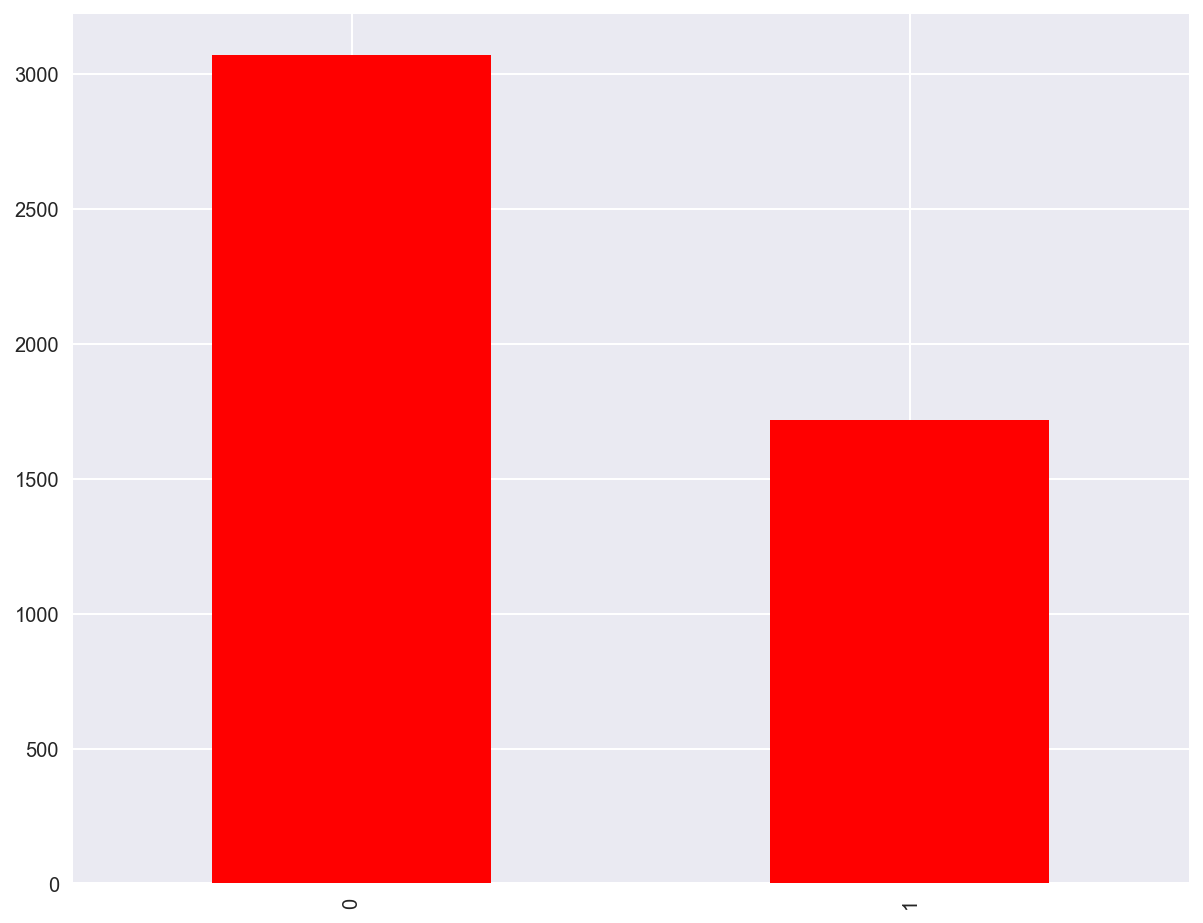

In [17]:
# Plot class counts of Brisbane (1) vs. Sydney (0)

hail_tweet_text_hail['event_class'].value_counts().plot(figsize=(10,8),kind='bar',color='red')

In [18]:
# Create Severity modelling dataframe:

# Remove twitter user data
X_hail_tweets = hail_tweet_text_hail.ix[:,26:]
print (X_hail_tweets.shape)

# Drop columns from dataframe relating to hail, location and event to create predictors
X_hail_tweets.drop(X_hail_tweets[['hail','hailstorm','event_class','australia','bnestorm','queensland','sydney',
                                  'sydneystorm','brisbane','brisbanestorm']], axis=1, inplace=True)
print (X_hail_tweets.shape)

(4786, 1000)
(4786, 990)


### _Random Forest Classification_

In [20]:
# transform our predictors
tf_transformer = TfidfTransformer(use_idf=False).fit(X_hail_tweets)
X_hail = tf_transformer.transform(X_hail_tweets)

# create train/test (0.8 split found to give fairly good performance)
X_train_hail, X_test_hail, y_train_hail, y_test_hail = train_test_split(X_hail_tweets, y_hail, test_size=0.8)

# set up RFC model with hyperparameters from hail model evaluation:
rfc_hail = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

# Extract the top features from the decision tree classifier.
rfc_hail.fit(X_train_hail, y_train_hail)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [21]:
# Extract the top features from the decision tree classifier.

top_features_rfc_hail = pd.DataFrame({
        'feature':X_hail_tweets.columns,
        'importance':rfc_hail.feature_importances_})

top_features_rfc_hail.sort_values('importance', ascending=False, inplace=True)
top_features_rfc_hail.head(20)

,feature,importance
757,slammed,0.051361
818,super,0.051156
138,chaos,0.045928
972,worst,0.039857
128,causes,0.033782
503,massive,0.030932
797,storm,0.027823
318,golf,0.018724
645,powerful,0.016238
860,thousands,0.015851


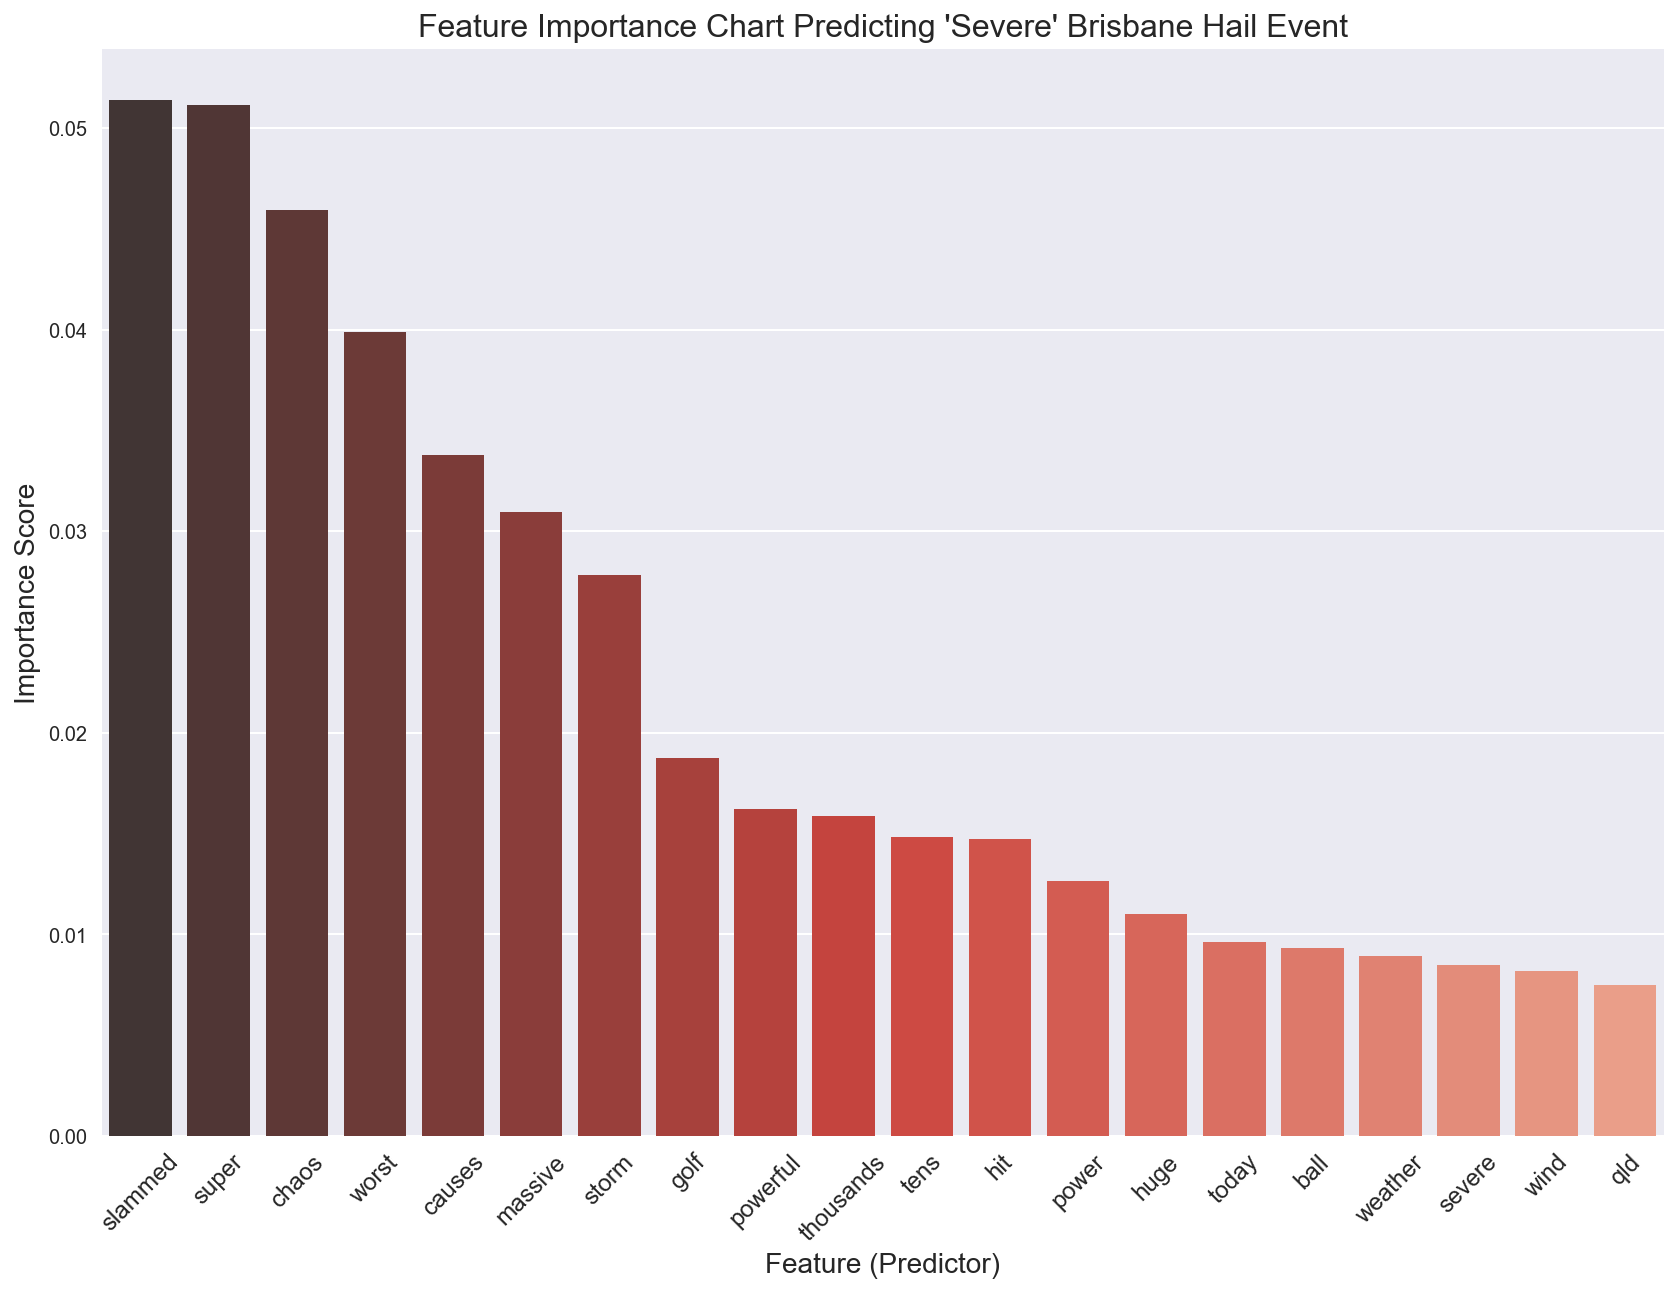

In [73]:
# "Hail"term frequency distribution plot over time

plt.figure(figsize=(14,10))
plt.title("Feature Importance Chart Predicting 'Severe' Brisbane Hail Event" ,size=16)
ax = sns.barplot(x='feature', y='importance', data=top_features_rfc_hail.head(20),ci=None,palette="Reds_d")
plt.xlabel('Feature (Predictor)',size=14)
plt.setp(ax.get_xticklabels(), rotation=45,size=12)
plt.ylabel('Importance Score',size=14)

In [22]:
rfc_hail_scores = cross_val_score(rfc_hail, X_test_hail, y_test_hail, cv=5)

print (rfc_hail_scores)
print (sum(rfc_hail_scores)/len(rfc_hail_scores))

# Create predicted y values

yhat_test_rfc_hail = rfc_hail.predict(X_test_hail)
yhat_test_rfc_hail_pp = rfc_hail.predict_proba(X_test_hail)

# convert the predicted and actual values to a confusion array

confusion_array_rfc = confusion_matrix(y_test_hail, yhat_test_rfc_hail, labels=[1,0])

confusion_rfc = pd.DataFrame(confusion_array_rfc, index=['severe','moderate'],
                         columns=['pred_severe','pred_moderate'])

print ("confusion matrix")
print (confusion_rfc)
print ("--------")
print ("accuracy:", accuracy_score(y_test_hail, yhat_test_rfc_hail)) # accuracy = (tp + tn) / total_population)
print ("--------")
print (classification_report(y_test_hail, yhat_test_rfc_hail))

[ 0.79400261  0.82506527  0.82506527  0.81437908  0.82745098]
0.817192644245
confusion matrix
          pred_severe  pred_moderate
severe            888            513
moderate          232           2196
--------
accuracy: 0.805432227736
--------
             precision    recall  f1-score   support

          0       0.81      0.90      0.85      2428
          1       0.79      0.63      0.70      1401

avg / total       0.80      0.81      0.80      3829



#### Hail Severity Summary

The hail severiy classification provides positive results.

- Whilst the accuracy score is lower than those in the hail prediction modelling, it is still high at 0.82.
- The true positive prediction (known severe hail tweets) of the test set is respectable, with high precision and moderate recall. This results in an overall f1 score of 0.8.
- The most important features that predict the 'severe' class are also consistent with terms we would usually associate with damaging hail events: ***slammed, super, chaos, worst, massive.***

Overall this initial investigation provides a very encouraging result and confidence that the tweet text can predict hail severity.

---

### 2. Earthquake Classification Investigation

In the tweet EDA we identified another type of natural catastrophe - an earthquake event in Nepal. The economic loss of this event is estimated to be in excess of USD 6 billion.

The serendipitous identification of another type of catastrophe in this study can let me investigate whether our optimal hail algorithm can also effectively identify tweets of a second type of catastrophe.

Firstly I will create a new class target using 'hail' and 'earthquake' text from our data previously prepared for modelling...

In [23]:
# Read in data:

hail_tweet_text = pd.read_csv("./hail_tweet_text.csv")
hail_tweet_text.drop('Unnamed: 0',axis=1,inplace=True)

Setting up the classification exercise with earthquake and hail classes (0, 1, 2)

In [24]:
# Create hail and earthquake classes

hail_tweet_text['catastrophe_class'] = 0

hail_tweet_text.ix[hail_tweet_text['hail'] >= 1, 'catastrophe_class'] = 1
hail_tweet_text.ix[hail_tweet_text['hailstorm'] >= 1, 'catastrophe_class'] = 1

hail_tweet_text.ix[hail_tweet_text['earthquake'] >= 1, 'catastrophe_class'] = 2
hail_tweet_text.ix[hail_tweet_text['quake'] >= 1, 'catastrophe_class'] = 2

y_total = hail_tweet_text['catastrophe_class']

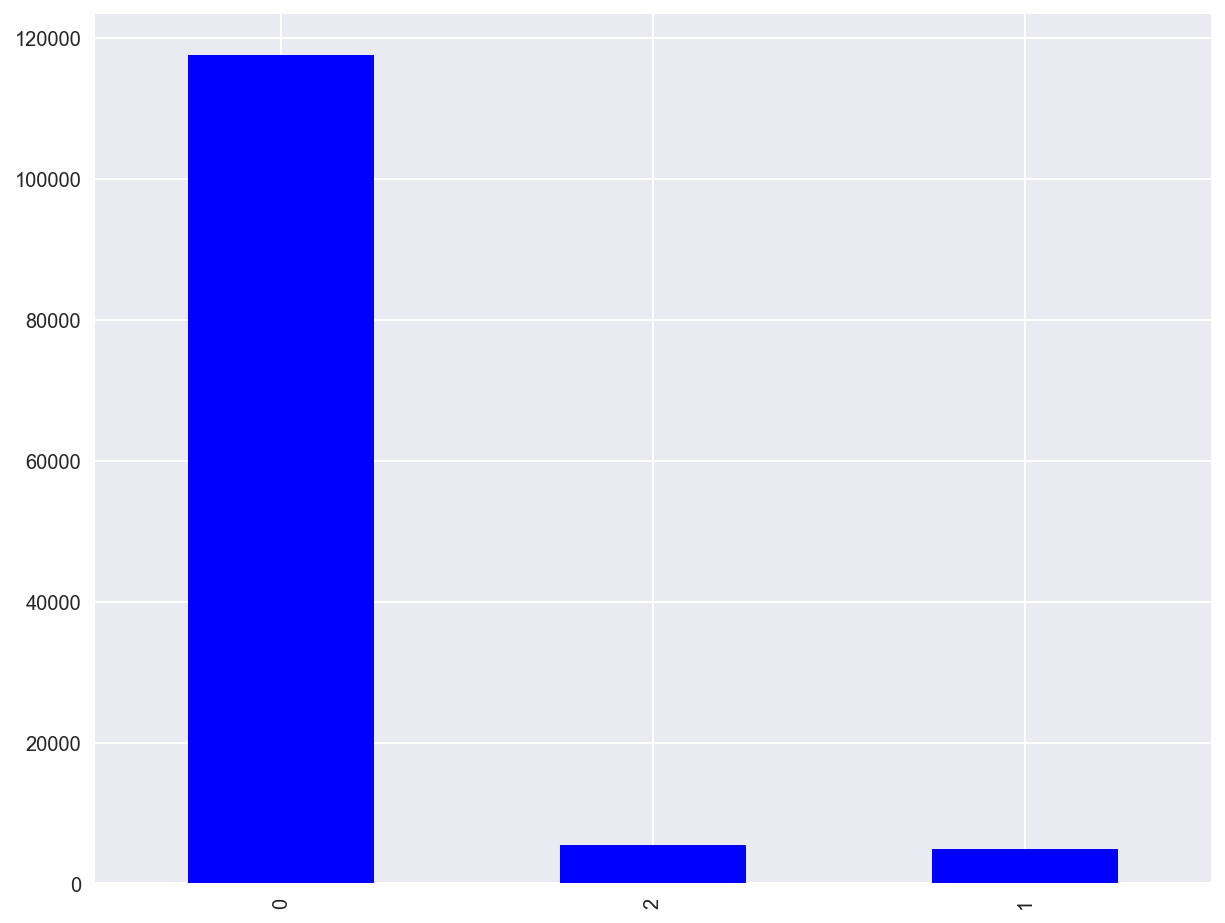

In [68]:
# Plot out earthquake, hail and 0 classes

hail_tweet_text['catastrophe_class'].value_counts().plot(figsize=(10,8),kind='bar',color='blue')

In [25]:
# Create predictors

htt_total = hail_tweet_text.ix[:,26:]
print (htt_total.shape)

htt_total.drop(htt_total[['hail','hailstorm','earthquake','quake','catastrophe_class']], axis=1, inplace=True)
print (htt_total.shape)

(127989, 1000)
(127989, 995)


### Random Forest Classification

I will now use the optimised algorithm from the hail identification modelling to see how well it identifies the more severe Brisbane event compared to Sydney.

In [33]:
# Transform a count matrix to a normalized tf or tf-idf representation
tf_transformer = TfidfTransformer(use_idf=False).fit(htt_total)
X_total_tf = tf_transformer.transform(htt_total)

In [34]:
# Create Train/Test data
X_train, X_test, y_train, y_test = train_test_split(X_total_tf, y_total, test_size=0.8)

# Set RFC with parameters indentified in gridsearching from hail idenification modelling
rfc_total = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

rfc_total.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [35]:
# Evaluate scores of RFC test set
rfc_scores = cross_val_score(rfc_total, X_test, y_test, cv=5)

print (rfc_scores)
print (sum(rfc_scores)/len(rfc_scores))

[ 0.96542969  0.96538086  0.96366833  0.96386189  0.96493627]
0.964655407531


In [36]:
# Create predicted y values

yhat_test_rfc = rfc_total.predict(X_test)
yhat_test_rfc_pp = rfc_total.predict_proba(X_test)

# convert the predicted and actual values to a confusion array

confusion_array_rfc = confusion_matrix(y_test, yhat_test_rfc, labels=[2,1,0])

confusion_rfc = pd.DataFrame(confusion_array_rfc, index=['eq', 'hail','no catastrophe'],
                         columns=['pred_eq','pred_hail', 'pred_no catastrophe'])
confusion_rfc

,pred_eq,pred_hail,pred_no
eq,3506,4,908
hail,0,1627,2260
no cat,413,386,93288


In [42]:
print (classification_report(y_test, yhat_test_rfc))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98     94087
          1       0.81      0.42      0.55      3887
          2       0.89      0.79      0.84      4418

avg / total       0.96      0.96      0.96    102392



#### Earthquake Classification Summary



---

### Link to [Notebook 5](capstone_technical_report_5_written_report.ipynb)

----